## Capstone Project: Quality and Quantity of Grocery Options by Zip Code in Wake County, NC
### Applied Data Science Capstone by Jon Puryear

### Table of Contents

#### Introduction / Business Problem

Wake County, NC is one of the fastest growing areas in the United States. However, there has been concern about access to grocery options in some parts of the county. Some parts of the county have been called a "Food Desert". a Food Desert is an urban area where it is difficuly to buy affordable food ro good-quality fresh food.

### Data Ingestion

#### Notebook Set-up

importing Python Modules needed to process the data for this business analysis

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # converts an address into Latitude and Longitude values
import folium # Map Rendering Library
import requests # Library to handle reqeuests
from sklearn.cluster import KMeans # Clustering Model
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

setting up Pandas to display all columns instead of truncating them

In [2]:
pd.options.display.max_columns = None

#### Foursquare Data

We will be using the Foursqaure Places API to pull in Venue information into this analysis. information on this API can be found at https://foursquare.com/developers/apps

**FourSquare API Credentials**

Setting up the variables needed for us to access the API later on in the notebook

In [3]:
CLIENT_ID = '-' # your Foursquare ID
CLIENT_SECRET = '-' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

#### IRS Tax Return Data

Data has been sourced from: IRS Information: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi

The Data was avaliable as an Excel file, so the file was downloaded and we using pandas read_excel function to create a dataset from it

In [4]:
irs_tax_data = pd.read_excel(r'2017_nc_irs_data.xlsx')

IRS Data is pretty dirty, and we only need to extract a few columns to bring into our analysis. Opening the File in Excel to give a visual reference of what is needed to proceed, we now write code to manipulate the data into a manageable dataset

**Clean up the Data Headers**

We Replace the existing headers with the new headers from row 2

First we define the row from which our new headers will be pulled from:

In [5]:
new_header = irs_tax_data.loc[2]

Then we create a new dataset by selecting from row inedx 3 and below from the initial dataload

In [6]:
clean_irs_data = irs_tax_data[3:]

now we add in the rows from the new_header variable back into the dataset as the new column names

In [7]:
clean_irs_data.columns = new_header

**Clean up Columns and Rows**

We only want Total Income and Number of returns from this dataset, at the Zip code aggregate level, so some manipulation is needed to parse out the zip code aggregate as well as pull over the income and count of returns

We start by getting the index location for the 'total income' column, the returns count is in the unlabelled column right next to it, so we need both of these columns

In [8]:
income_index = clean_irs_data.columns.get_loc('Total income')

Now that we know where the 'total income' column is, we can limit our datset to the key information

In [9]:
# Check to see if this can be removed
# cols = [clean_irs_data[:2], clean_irs_data[income_index:income_index+2]]

In [10]:
clean_irs_data = clean_irs_data.iloc[:, [0,1,income_index, income_index +1]]

Rename the columns to be more descriptive - we only need the gross_income column as a way to help up identify the zip code aggregate levels in the data, as this field is null in the gross_income column at the zip code aggreate level

In [11]:
clean_irs_data.columns = ['ZIPCODE', 'gross_income', 'returns_count', 'total_income']

Set the null values to 'zip_total'

In [12]:
clean_irs_data.fillna(value = 'zip_total', inplace = True)

clear out the un-needed rows from the dataset by filtering on 'zip_total' across several fields

In [13]:
clean_irs_data = clean_irs_data.loc[clean_irs_data['ZIPCODE'] != 'zip_total']

In [14]:
clean_irs_data = clean_irs_data.loc[clean_irs_data['gross_income'] == 'zip_total']

Reset the Index and then drop the extraneous Index field from the dataset

In [15]:
clean_irs_data.reset_index(inplace = True)

In [16]:
clean_irs_data.drop(columns = ['index'], inplace = True)

We no longer need 'gross_income' so dropping it from the dataset

In [17]:
clean_irs_data.drop(columns = ['gross_income'], inplace = True)

per the IRS Dataset, the total_income value is in Thousands, so we will convert it to regular dollars by * 1000

In [18]:
clean_irs_data['total_income'] = (clean_irs_data['total_income'] * 1000)

We now have a nice clean IRS dataset

In [19]:
clean_irs_data.head()

,ZIPCODE,returns_count,total_income
0,27006,6900,723443000
1,27007,900,44445000
2,27009,1320,108203000
3,27011,2340,108120000
4,27012,13550,1209830000


#### Wake County Zip Codes

Wake County Zip Codes will be sourced from Zillow.com, which is a real estate site, and confirmed against official Wake County publications (which are ony available in Image Formats). This will be used to determine the Zip Code scope of the Analysis

Wake County Zip Codes: http://data-wake.opendata.arcgis.com/datasets/zip-codes/data

GeoService: https://maps.wakegov.com/arcgis/rest/services/Boundaries/ZipCodes/MapServer/0/query?outFields=*&where=1%3D1

We pull in the zip codes using pandas read_csv

In [20]:
wake_county_zip_codes = pd.read_csv(r'Zip_Codes.csv')

This dataset looks very clean already, we just need to trim the uneeded data from the dataset

In [21]:
wake_county_zip_codes.head()

,OBJECTID,ZIPNAME,ZIPNUM,ZIPCODE,NAME,SHAPEAREA,SHAPELEN,LAST_EDITED_DATE
0,4927,RALEIGH,27601.0,RALEIGH 27601,RALEIGH,5.075530e+07,43034.538745,NaN
1,4928,DURHAM,27713.0,DURHAM 27713,DURHAM,9.440600e+06,22633.644539,NaN
2,5185,RALEIGH,27604.0,RALEIGH 27604,RALEIGH,5.678501e+08,201307.097948,NaN
3,5186,WAKE FOREST,27587.0,WAKE FOREST 27587,WAKE FOREST,2.682834e+09,561415.191124,2017/10/25 15:38:04+00
4,5187,DURHAM,27703.0,DURHAM 27703,DURHAM,5.768992e+06,22448.009933,NaN


Define the columns to be dropped

In [22]:
drop_cols = {'OBJECTID','ZIPCODE', 'NAME', 'SHAPEAREA','SHAPELEN', 'LAST_EDITED_DATE'}

and drop them from the dataset

In [23]:
wake_county_zip_codes.drop(columns = drop_cols, inplace = True)

In [24]:
#Convert from floats / Strings to Ints

check for any Null values in the dataset...

In [25]:
wake_county_zip_codes[wake_county_zip_codes.isna().any(axis = 1)]

,ZIPNAME,ZIPNUM
42,NaN,NaN
43,NaN,NaN
44,NaN,NaN
45,NaN,NaN
46,NaN,NaN
47,NaN,NaN
48,NaN,NaN
49,NaN,NaN
50,NaN,NaN
51,NaN,NaN


and remove them..

In [26]:
wake_county_zip_codes.dropna(inplace = True)

Create a new ZIPCODE Column

In [27]:
wake_county_zip_codes['ZIPCODE'] = wake_county_zip_codes['ZIPNUM'].astype(int)

and remove the ZIPNUM column

In [28]:
wake_county_zip_codes.drop(columns = ['ZIPNUM'], inplace = True)

Add in a concatenated column for Neighborhood

In [29]:
wake_county_zip_codes['Neighborhood'] = wake_county_zip_codes['ZIPNAME'] + ' - ' + wake_county_zip_codes['ZIPCODE'].astype(str)

Final Dataset looks like this:

In [30]:
wake_county_zip_codes.head()

,ZIPNAME,ZIPCODE,Neighborhood
0,RALEIGH,27601,RALEIGH - 27601
1,DURHAM,27713,DURHAM - 27713
2,RALEIGH,27604,RALEIGH - 27604
3,WAKE FOREST,27587,WAKE FOREST - 27587
4,DURHAM,27703,DURHAM - 27703


#### Geographical Data for Zip Codes

Zip Code Data: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html

In [31]:
zip_code_geo_data = pd.read_csv(r'2019_Gaz_zcta_national.txt', delimiter = '\t')

In [32]:
zip_code_geo_data.head()

,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,601,166659747,799292,64.348,0.309,18.180555,-66.749961
1,602,79307534,4428428,30.621,1.710,18.361945,-67.175597
2,603,81887188,181412,31.617,0.070,18.455183,-67.119887
3,606,109579993,12487,42.309,0.005,18.158327,-66.932928
4,610,93013428,4172059,35.913,1.611,18.294032,-67.127156


The GEOID in this dataset is the Zip Code, so we will create the column

In [33]:
zip_code_geo_data['ZIPCODE'] = zip_code_geo_data['GEOID']

and then drop all the columns we do not need

In [34]:
drop_cols = {'GEOID','ALAND', 'AWATER', 'ALAND_SQMI','AWATER_SQMI'}
zip_code_geo_data.drop(columns = drop_cols, inplace = True)

Final Dataset looks like this:

In [35]:
zip_code_geo_data.head()

,INTPTLAT,INTPTLONG,ZIPCODE
0,18.180555,-66.749961,601
1,18.361945,-67.175597,602
2,18.455183,-67.119887,603
3,18.158327,-66.932928,606
4,18.294032,-67.127156,610


### Common Dataset for Wake County

We want to start to build a single dataset from the three we have imported.

We will start with the wake_county_zip_codes dataset since it is already limited to the level they is needed for this analysis (Zip Codes in Wake Count)

We will then incorporate the zip code geo data before we use the foursquare API. We won't incorporate the IRS information until after we have compiled and processed the venue information from foursquare

**Build Base Dataset**

We will use the wake county zip codes dataset as our base

In [36]:
wake_county_dataset = wake_county_zip_codes

**Add in Location Information**

Now we merge the zip code geo data into the bsae dataset

In [37]:
wake_county_dataset = pd.merge(wake_county_dataset, zip_code_geo_data, on = 'ZIPCODE', how = 'left')

Now we rename the columns to be more descriptiive

In [38]:
wake_county_dataset.columns

Index(['ZIPNAME', 'ZIPCODE', 'Neighborhood', 'INTPTLAT',
       'INTPTLONG                                                                                                                                  '],
      dtype='object')

In [39]:
wake_county_dataset.columns = ['ZIPNAME', 'ZIPCODE', 'Neighborhood','LAT', 'LON']

our base dataset is now:

In [40]:
wake_county_dataset.head()

,ZIPNAME,ZIPCODE,Neighborhood,LAT,LON
0,RALEIGH,27601,RALEIGH - 27601,35.773630,-78.634458
1,DURHAM,27713,DURHAM - 27713,35.895040,-78.923747
2,RALEIGH,27604,RALEIGH - 27604,35.822921,-78.562045
3,WAKE FOREST,27587,WAKE FOREST - 27587,35.981382,-78.557584
4,DURHAM,27703,DURHAM - 27703,35.959272,-78.806808


**Descriptive Stats**

In [41]:
wake_county_dataset.shape

(55, 5)

In [42]:
len(wake_county_dataset['ZIPCODE'].unique())

39

Drop any Duplicates in the data

In [43]:
wake_county_dataset = wake_county_dataset.drop_duplicates()

Check the dataset post-removal of duplicates

In [44]:
wake_county_dataset.shape

(39, 5)

The shape matched the unique records now, so we are ready to proceed...

In [45]:
## Need to add in Income Information next

### Visualze the Zip Code centroids

**Use the geopy library to get the latitude and longitude values of Wake County, NC**

in order to define an instance of the geocode, we need to define a user_agent. The agent will be named *nc_explore*

In [46]:
address = 'Wake County, NC'

geolocator = Nominatim(user_agent = 'nc_explore')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of {} are {}, {}'.format(address, latitude, longitude))

The geographical coordinates of Wake County, NC are 35.7979355, -78.6118311


**Create a Map of Wake County with the Zip Codes superimposed on it**

Create the initial map instance

In [47]:
map_wake = folium.Map(location = [latitude, longitude], zoom_start = 11)

Add markers to the map for each neighborhood

In [48]:
for lat, lng, label in zip(wake_county_dataset['LAT'], wake_county_dataset['LON'], wake_county_dataset['ZIPNAME'] + ' - ' + wake_county_dataset['ZIPCODE'].astype(str)):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_wake)

Display the resultant map

In [49]:
#map_wake

### Pulling in Grocery Data from Foursquare API



We are going to define a function below that will pass each record thorugh to the forusquare API and return all the recommended venues in a 5 mile radius

In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius = 8047):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

Now, we set-up the variables using the wake_county_dataset so we can run our foursuqare function

In [51]:
names = wake_county_dataset['ZIPNAME'] + ' - ' + wake_county_dataset['ZIPCODE'].astype(str)
latitudes = wake_county_dataset['LAT']
longitudes = wake_county_dataset['LON']

We now define a new dataset to collect this unformation from foursquare and run our function...

In [53]:
wake_venues = getNearbyVenues(names, latitudes, longitudes)

RALEIGH - 27601
DURHAM - 27713
RALEIGH - 27604
WAKE FOREST - 27587
DURHAM - 27703
ROLESVILLE - 27571
KNIGHTDALE - 27545
RALEIGH - 27603
CREEDMOOR - 27522
YOUNGSVILLE - 27596
RALEIGH - 27615
RALEIGH - 27616
RALEIGH - 27612
WENDELL - 27591
RALEIGH - 27609
RALEIGH - 27605
APEX - 27502
GARNER - 27529
RALEIGH - 27608
RALEIGH - 27610
CLAYTON - 27520
ANGIER - 27501
RALEIGH - 27613
RALEIGH - 27614
CARY - 27518
APEX - 27523
RALEIGH - 27617
ZEBULON - 27597
CARY - 27511
CARY - 27519
CARY - 27513
RALEIGH - 27607
RALEIGH - 27606
MORRISVILLE - 27560
APEX - 27539
FUQUAY VARINA - 27526
NEW HILL - 27562
WILLOW SPRING - 27592
HOLLY SPRINGS - 27540


**Dataset Exploration**

The dataset looks as below

In [54]:
wake_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,RALEIGH - 27601,35.77363,-78.634458,Artspace Visual Arts Center,35.775576,-78.636335,Art Gallery
1,RALEIGH - 27601,35.77363,-78.634458,Burial Beer Co.,35.775241,-78.632247,Brewery
2,RALEIGH - 27601,35.77363,-78.634458,Bida Manda Laotian Restaurant and Bar,35.777227,-78.636812,Asian Restaurant
3,RALEIGH - 27601,35.77363,-78.634458,Duke Energy Center For The Performing Arts,35.771314,-78.639560,Performing Arts Venue
4,RALEIGH - 27601,35.77363,-78.634458,Beasley's Chicken + Honey,35.776968,-78.638175,Southern / Soul Food Restaurant


In [55]:
wake_venues.shape

(3332, 7)

In [56]:
print('There are {} unique Venue Categories'.format(len(wake_venues['Venue Category'].unique())))

There are 223 unique Venue Categories


In [57]:
print('There are {} unique Venues'.format(len(wake_venues['Venue'].unique())))

There are 1249 unique Venues


In [58]:
wake_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ANGIER - 27501,27,27,27,27,27,27
APEX - 27502,87,87,87,87,87,87
APEX - 27523,73,73,73,73,73,73
APEX - 27539,100,100,100,100,100,100
CARY - 27511,100,100,100,100,100,100


#### Filter the Venues


Now we need to filter out the non-Grocery Venues - Looking at the documentation from te foursquare API, we can discover that there are two primary venue categories for "Food Stores". These are Grocery Store, Organic Grocery and Supermarket

We create a sub dataset called wake_grocery_venues

In [59]:
wake_grocery_venues = wake_venues.loc[(wake_venues['Venue Category'] == 'Grocery Store') | (wake_venues['Venue Category'] == 'Organic Grocery') | (wake_venues['Venue Category'] == 'Supermarket')]

In [60]:
wake_grocery_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
83,RALEIGH - 27601,35.773630,-78.634458,The Fresh Market,35.789598,-78.658642,Grocery Store
153,DURHAM - 27713,35.895040,-78.923747,Harris Teeter,35.912543,-78.936125,Supermarket
184,DURHAM - 27713,35.895040,-78.923747,Harris Teeter,35.918031,-78.958794,Supermarket
214,RALEIGH - 27604,35.822921,-78.562045,Trader Joe's,35.823443,-78.621513,Grocery Store
218,RALEIGH - 27604,35.822921,-78.562045,Wegmans,35.820860,-78.620792,Grocery Store


#### Counting the Venues

For this we will use a machine learning technique called onhot encoding to convert our categorizal Venue Category Variable into a numeric one

In [61]:
wake_onehot = pd.get_dummies(wake_grocery_venues[['Venue Category']], prefix = '', prefix_sep = '')

In [62]:
wake_onehot['Neighborhood'] = wake_grocery_venues['Neighborhood']

In [63]:
nh_index = wake_onehot.columns.get_loc('Neighborhood')

In [64]:
cols = [wake_onehot.columns[nh_index]] + list(wake_onehot.columns[:nh_index]) + list(wake_onehot.columns[nh_index + 1:])

In [65]:
wake_onehot = wake_onehot[cols]

In [66]:
wake_group = wake_onehot.groupby('Neighborhood').sum().reset_index()

This results in a dataset with the counts of the Food Stores by Neighborhood

In [67]:
wake_group.head()

,Neighborhood,Grocery Store,Supermarket
0,ANGIER - 27501,2,0
1,APEX - 27502,1,3
2,APEX - 27523,3,1
3,APEX - 27539,4,1
4,CARY - 27511,3,2


In [68]:
wake_group.shape

(38, 3)

However, it looks like one Neighborhood does not have ANY food stores within 5 miles, so we will need to remember to account for this later on in the analysis

Now we merge this new informaiton back into a new merged dataset

In [71]:
wake_merged = wake_county_dataset
wake_merged = wake_merged.join(wake_group.set_index('Neighborhood'), on = 'Neighborhood')

Now we fill in the missing Venue Counts

In [72]:
wake_merged.fillna(value = 0, inplace = True)

and add a new Key indicator called **food_store_count**

In [73]:
wake_merged['food_store_count'] = wake_merged['Grocery Store'] + wake_merged['Supermarket']

### Integrate IRS Data into Dataset

Now we join our merged dataset with the IRS data to get our household and income information

In [74]:
wake_merged = wake_merged.join(clean_irs_data.set_index('ZIPCODE'), on = 'ZIPCODE', how = 'left')

In [75]:
wake_merged.head()

,ZIPNAME,ZIPCODE,Neighborhood,LAT,LON,Grocery Store,Supermarket,food_store_count,returns_count,total_income
0,RALEIGH,27601,RALEIGH - 27601,35.773630,-78.634458,1.0,0.0,1.0,4340,289082000
1,DURHAM,27713,DURHAM - 27713,35.895040,-78.923747,0.0,2.0,2.0,26260,1989180000
2,RALEIGH,27604,RALEIGH - 27604,35.822921,-78.562045,4.0,0.0,4.0,21720,1130719000
3,WAKE FOREST,27587,WAKE FOREST - 27587,35.981382,-78.557584,4.0,3.0,7.0,30920,2993556000
4,DURHAM,27703,DURHAM - 27703,35.959272,-78.806808,0.0,2.0,2.0,27620,1576820000


Calculate the average reported Income per Household, **income_per_household**, which is another Key Indicator

In [76]:
wake_merged['income_per_household'] = (wake_merged['total_income'] / wake_merged['returns_count'] )

Calculate the average # of Households that each food store serves, **households_served** which is another Key indicator

In [77]:
wake_merged.reset_index(inplace = True)

In [78]:
wake_merged['households_served'] = 0

In [79]:
for i in range(len(wake_merged)):
    if wake_merged.loc[i, 'food_store_count'] == 0:
        wake_merged.loc[i, 'households_served'] = 0
    else:
        wake_merged.loc[i, 'households_served'] = (wake_merged.loc[i, 'returns_count'] / wake_merged.loc[i, 'food_store_count'].astype(int))

In [82]:
wake_merged.dtypes

index                     int64
ZIPNAME                  object
ZIPCODE                  object
Neighborhood             object
LAT                     float64
LON                     float64
Grocery Store           float64
Supermarket             float64
food_store_count        float64
returns_count           float64
total_income            float64
income_per_household    float64
households_served       float64
dtype: object

In [83]:
wake_merged['returns_count'] = wake_merged['returns_count'].astype(float)
wake_merged['total_income'] = wake_merged['total_income'].astype(float)
wake_merged['income_per_household'] = wake_merged['income_per_household'].astype(float)

### Data Visualization

In this section we will be generating several visualizations that will be used to form our conclusions

**Scatterplot of Income per Household ver Households Served**

<AxesSubplot:xlabel='households_served', ylabel='income_per_household'>

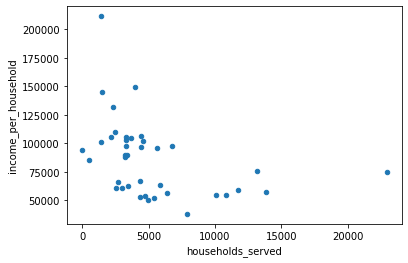

In [84]:
wake_merged.plot.scatter(x = 'households_served', y = 'income_per_household') 

**Bubbleplot of Income per Household ver Households Served ver Total Returns Submitted**

<AxesSubplot:xlabel='households_served', ylabel='income_per_household'>

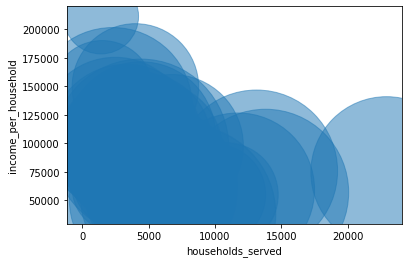

In [86]:
wake_merged.plot.scatter(x = 'households_served', y = 'income_per_household', s = wake_merged['returns_count'], alpha = 0.5) 

**Histograms of Four of the Key Indicators**

<function matplotlib.pyplot.show(close=None, block=None)>

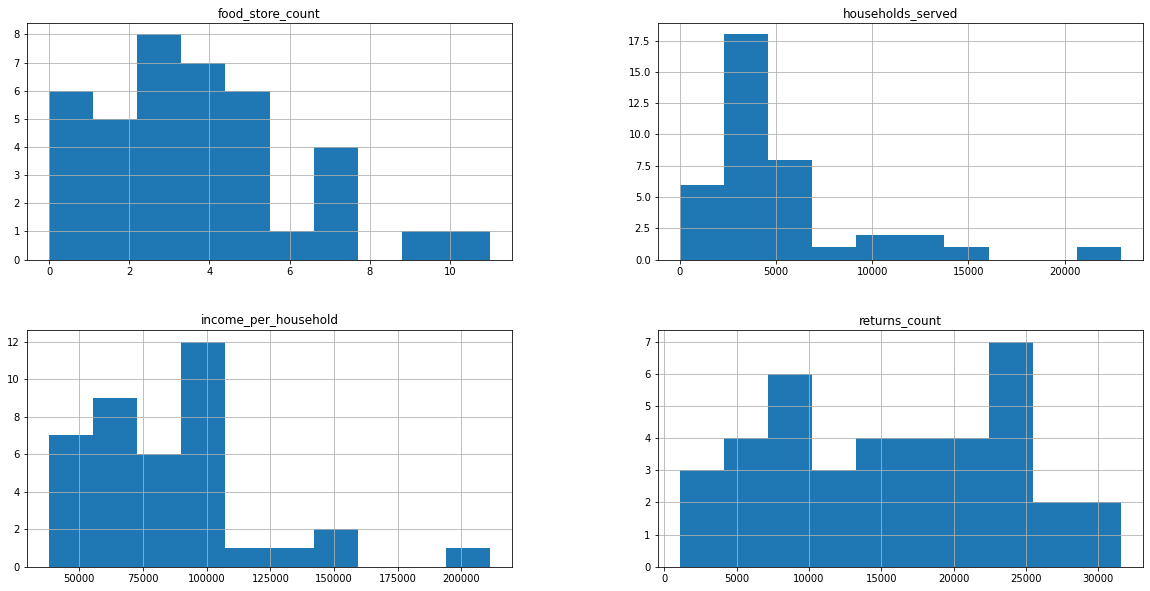

In [105]:
viz = wake_merged[['households_served','food_store_count', 'income_per_household', 'returns_count']]
viz.hist()
plt.show

**Scatterplot of Returns Count ver Households Served**

<AxesSubplot:xlabel='households_served', ylabel='returns_count'>

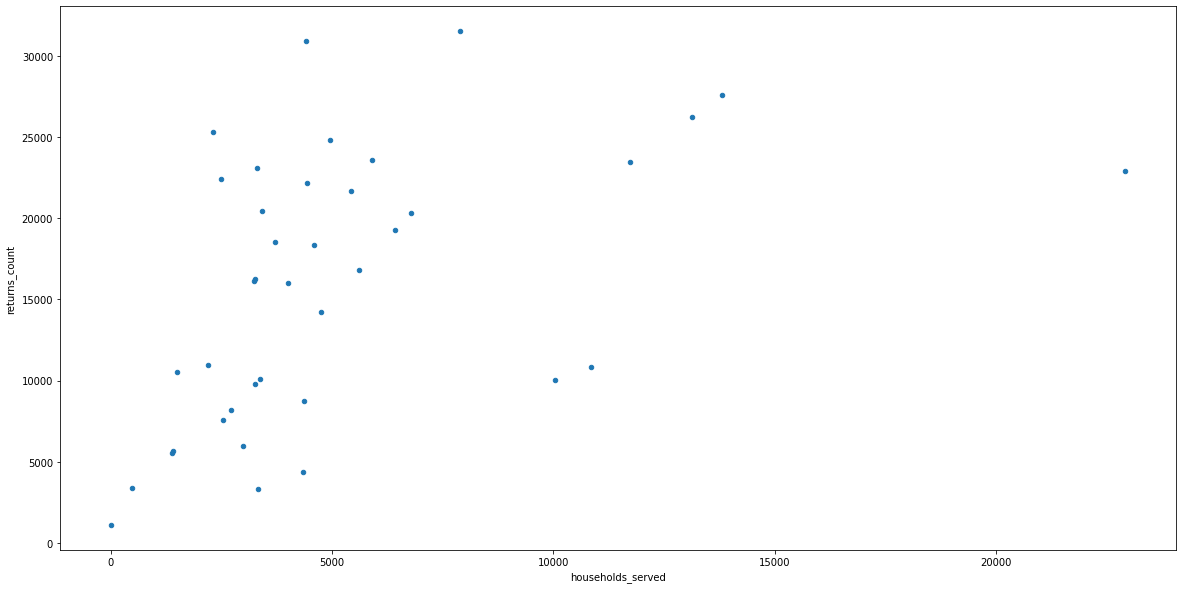

In [106]:
wake_merged.plot.scatter(x = 'households_served', y = 'returns_count') 

**Under Served Zip Codes**

10,000 households served per Food Store seems to be a deliniation between "Served" and "Over Served"

Show the Data for where households_served > 10,0000 - add an indicator

In [89]:
wake_merged['under_served'] = 0
wake_merged.loc[wake_merged['households_served'] >= 10000, 'under_served'] = 1

Do a groupby on Underserved

In [94]:
households_underserved = wake_merged.groupby('under_served').sum()

In [108]:
households_underserved

,index,LAT,LON,Grocery Store,Supermarket,food_store_count,returns_count,total_income,income_per_household,households_served
under_served,,,,,,,,,,
0,756,1181.253247,-2596.813817,81.0,61.0,142.0,497200.0,4.364509e+10,2.994840e+06,120742.116162
1,113,214.679029,-471.838965,1.0,8.0,9.0,121140.0,7.820426e+09,3.769389e+05,82470.000000


<AxesSubplot:ylabel='returns_count'>

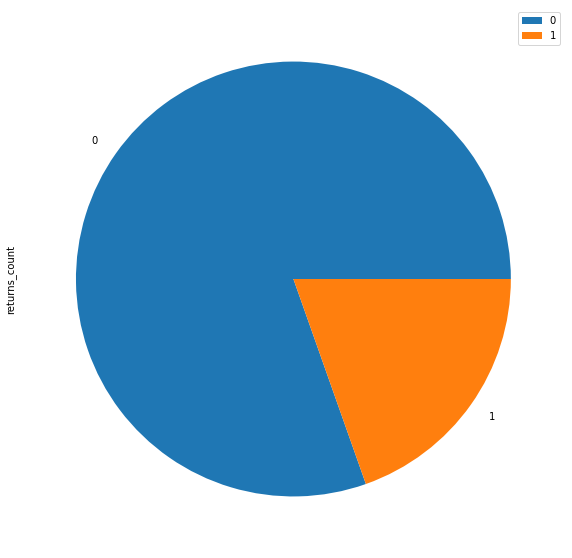

In [107]:
households_underserved.plot.pie(y = 'returns_count')

**General Description of the Dataset**

In [97]:
wake_merged.describe()

,index,LAT,LON,Grocery Store,Supermarket,food_store_count,returns_count,total_income,income_per_household,households_served,under_served
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,3.900000e+01,39.000000,39.000000,39.000000
mean,22.282051,35.793135,-78.683405,2.102564,1.769231,3.871795,15854.871795,1.319629e+09,86455.877481,5210.567081,0.153846
std,13.412384,0.133357,0.162018,1.651074,1.286806,2.341609,8318.259836,7.866014e+08,33709.990478,4375.824112,0.365518
min,0.000000,35.484941,-78.990017,0.000000,0.000000,0.000000,1080.000000,1.015480e+08,38095.849176,0.000000,0.000000
25%,11.500000,35.725385,-78.804690,1.000000,1.000000,2.000000,9270.000000,5.789335e+08,60124.125722,2859.166667,0.000000
50%,23.000000,35.801980,-78.675202,2.000000,2.000000,4.000000,16280.000000,1.259805e+09,87763.206388,4005.000000,0.000000
75%,32.500000,35.880777,-78.574269,3.000000,2.500000,5.000000,22675.000000,1.789994e+09,102313.290043,5754.166667,0.000000
max,47.000000,36.105618,-78.303150,7.000000,5.000000,11.000000,31560.000000,3.337674e+09,211302.831858,22920.000000,1.000000


**Food Store Data Distribution**

<AxesSubplot:>

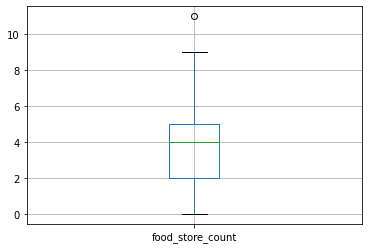

In [98]:
wake_merged.boxplot(column = ['food_store_count'])

**House Holds Served Data Distribution**

<AxesSubplot:>

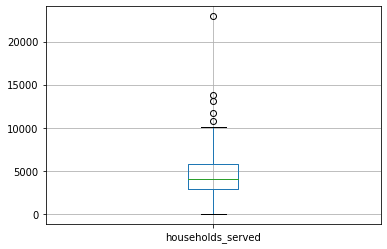

In [99]:
wake_merged.boxplot(column = ['households_served'])

In [100]:
plt.rcParams['figure.figsize'] = (20,10)

**Households Served per Food Store by Neighborhood**

<AxesSubplot:xlabel='Neighborhood'>

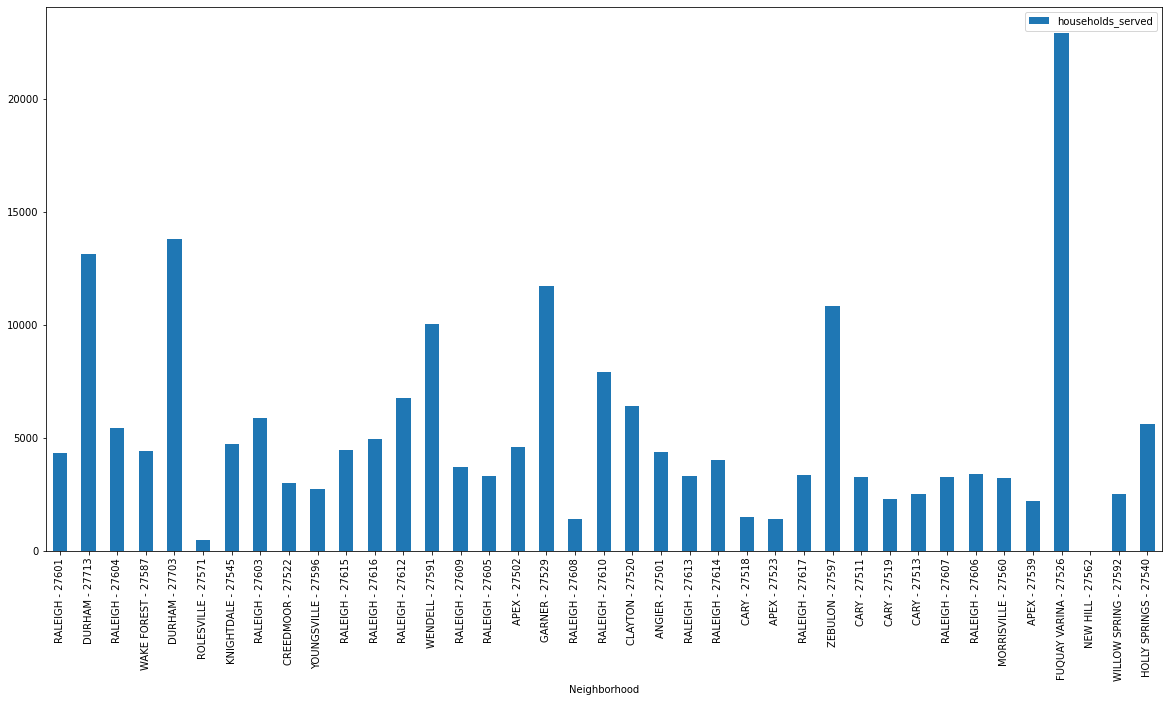

In [101]:
wake_merged.plot.bar(x = 'Neighborhood', y = 'households_served')

**Data Correlation**

This will determine if there is any correlation between the Income and Count of Food Stores..

<AxesSubplot:>

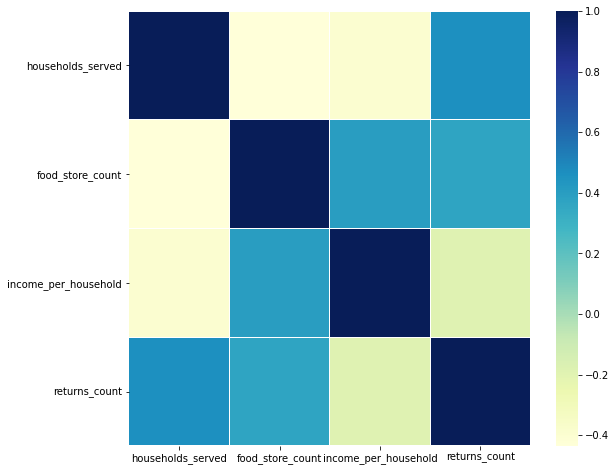

In [102]:
import seaborn as sns
corrmat = viz.corr()

f, ax = plt.subplots(figsize = (9, 8))
sns.heatmap(corrmat, ax = ax, cmap = 'YlGnBu', linewidths = 0.1)


The chart above shows that there is no correlation between Households Served and Income Per Household

#### Visualize the Underserved Neighborhoods Geographically

Use the Served . Underserved value to distinguish between colors of the neighborhood

In [104]:
#create map

map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

#Set color scheme for the clusters
x = 2
ys = [i + x + (i * x)**2 for i in range(2)]
cmap = cm.get_cmap('rainbow')
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cmap(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(wake_merged['LAT'], wake_merged['LON'], wake_merged['Neighborhood'], wake_merged['under_served']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster) - 1],
        fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters

Looks like Geogprahy is more of a factor than Income when it comes to the quality and quantity of Grocery Services

### Conclusions

Based on the information, it appears that Geograhoy is the primary factor, not income or population.

Majority of the Under Served locations are in Rural Areas. 